# Generating model inputs from raw audio

Generating spectrograms and then saving those images as _images_ loses much of the information stored in the spectrogram input data. The spectrogram input is a complex-valued matrix D, consisting of magnitude and phase of frequency bin f at frame t. A plotted spectrogram shows time on the x-axis, frequency on the y-axis, with amplitude/intensity/decibels as color.  The data here have a minimum sample rate of 50KHz, signifying 50,000 samples per second for the :30 clip. The frequency and time binning done to generate a spectrogram array groups these 1.5M+ samples into windows of specified length. 

The 12.5-25KHz frequency band encompasses most of the whistle vocalizations of the target species; their clicks are broadband and should be visible in this frequency as well.

If transposing the resulting image to a .png and reimporting, the resulting matrix dimensions represent pixels (based on physical size of export), and resulting matrix values represent color on a different scale than audio intensity. To feed _spectrograms_ to CNN, what we want is the true spectrogram matrix, not the matrix of a .png rendering of the audio data. The spectrogram matrix is derived from the audio file via the **short-time Fourier transform (stft)**. The stft divides the total interval (:30) into smaller segments and computes a Fourier transform on each one; plotting these spectra sequentially (over time) gives us a spectrogram. 

---
Parameters used herein, based on marine mammal and underwater acoustic literature review. Note: I created 2 separate folders of spectrograms for processing because I was initially confronted with memory limitations. The code below contains the parameters for the smaller, downsampled matrices since that is what was run last. These were ultimately not used in model training/testing as I was able to upscale back to the larger variety.  The specs for the smaller variety are in the code, while the specs for the variety used in the rest of this project are as follows:
* sr = 50KHz --> all data are either 50k or 64k; resample the 64k files to 50k so working with equal times per frame
* n_fft=4096; downsized to accommodate hardware limitations. Ideal was n_fft>=8192 (based on methods from Thomas et al 2019, and applying to the unique attributes of _S. longirostris_ vocalizations)
    * _( n_fft=2048 in this notebook to generate the lower-resolution output )_
* win_length = n_fft
* hop_length = n_fft/2; also downsized, ideal was win_length/4
    * _( hop_length = n_fft/1.25 in this notebook to generate the lower-resolution data )_
* window: Hann window
* resulting matrices: 610 x 368
    * _( low-res versions: 307 x 460 )_
    
---
  
This notebook generates spectrogram matrices for training and test data with Librosa's stft function.



In [1]:
import pandas as pd
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import os
import wave
import librosa
import librosa.display
import IPython.display as ipd
import pickle
import random

## Step 1. set aside holdout set
This set will remain separate from regular train/test data for final validation.  
500 positive files, 1538 negative files

In [2]:
#relocate positives and negatives from existing folders to holdout folders
def define_holdout(n_pos, pos_origin, pos_dest, n_neg, neg_origin, neg_dest):
    import shutil
    
    #positives
    for i in range(n_pos):
        shutil.move(pos_origin + np.random.choice(os.listdir(pos_origin)), pos_dest)
        
    #negatives
    for j in range(n_neg):
        shutil.move(neg_origin + np.random.choice(os.listdir(neg_origin)), neg_dest)
        
    print(f'# positives in holdout: {len(os.listdir(pos_dest))}')
    print(f'# negatives in holdout: {len(os.listdir(neg_dest))}')
    print(f'# pos for tts: {len(os.listdir(pos_origin))}')
    print(f'# neg for tts: {len(os.listdir(neg_origin))}')

In [3]:
pos_origin = '../scratch_data/yes_dolphin/'
pos_dest = '../scratch_data/holdout/positives'
neg_origin = '../scratch_data/no_dolphin/'
neg_dest = '../scratch_data/holdout/negatives'

# define_holdout(500, pos_origin, pos_dest, 1538, neg_origin, neg_dest)

# positives in holdout: 501
# negatives in holdout: 1538
# pos for tts: 5588
# neg for tts: 16766

## Step 2. Create spectrograms for tts
* Pos and Neg files currently only differentiated by directory; attach label (Yes/No) here
* Trim arrays to only frequencies over 10KHz; critical range 12.5KHz-25KHz
    * If data size still unweildy, trim to 12KHz
    * rows to trim indicated by fft_freq results
* Save spectrogram matrices and labels in list(s), save list via pickle or librosa cache?

In [3]:
#index of frequency bins that are below threshold depend on features of stft
#function to define lower threshold

def thresh(array, thresh_hz):
    vals=[]
    for i in range(len(array)):
        vals.append(abs(thresh_hz-array[i]))
    return vals.index(min(vals)) #returns index of almost-thresh value in ascending list

In [4]:
#example
freq_key = librosa.fft_frequencies(sr=50000, n_fft=4096)
thresh(freq_key, 10000)
#indicates trim stft array to [820:]

819

In [7]:
#redefine thresh here so can run as single cell
#(thresh fx called in listospects)
def thresh(array, thresh_hz):
    vals=[]
    for i in range(len(array)):
        vals.append(abs(thresh_hz-array[i]))
    return vals.index(min(vals))


def listospects(in_path, samp_rate, n_fft, win_length, hop_length, 
                window, pos_neg, low_thresh, ex_path):
    import pickle
    
    freq_key = librosa.fft_frequencies(sr=samp_rate, n_fft=n_fft)
    z = thresh(freq_key, low_thresh)
    
    
    files = os.listdir(in_path)
    spectrolist = []
    count = 1
    
    for i in files:
        y, sr = librosa.load(in_path + i, sr=samp_rate)
        S = np.abs(librosa.stft(y, n_fft=n_fft, win_length=win_length, hop_length=hop_length,
                               window=window))
        
        #start at low_f threshold (z), downsample both axes for compression
        #trim the last few t frames bc some files differ by +/- 2 and want even dim for all
        trim = S[z+1:(S.shape[0]):2, :920:2] #ADJUST T UPPER LIMIT IF CHANGE FFT or HOP_L
                
        spectrolist.append(trim)
        
        if len(spectrolist) % 1000 == 0:
            print(len(spectrolist))
            
        if len(spectrolist) % 3000 == 0: #save results so far and start anew (wary of pickle size limits)
            with open(f'{ex_path}tts_{count}_{pos_neg}.pkl', mode = 'wb') as pickle_out:
                pickle.dump(spectrolist, pickle_out)
            count += 1
            spectrolist = []
            
    #export whatever's in list when pau        
    if len(spectrolist) > 0:
        with open(f'{ex_path}tts_{count}_{pos_neg}.pkl', mode = 'wb') as pickle_out:
            pickle.dump(spectrolist, pickle_out)
            
    print("thanks for all the fish")

In [8]:
#positive IDs first
in_path = '../scratch_data/yes_dolphin/'
ex_path = '../scratch_data/tts_arrays_sm/'
yes_tts = listospects(in_path=in_path, samp_rate=50000, n_fft=2048, win_length=2048, 
                      hop_length=int(2048/1.25), window=signal.windows.hann, pos_neg='pos',
                      low_thresh=10000, ex_path=ex_path)

1000
2000
3000
1000
2000
thanks for all the fish


In [10]:
#negative IDS. 4:30 not too bad
in_path = '../scratch_data/no_dolphin/'
ex_path = '../scratch_data/tts_arrays_sm/'
yes_tts = listospects(in_path=in_path, samp_rate=50000, n_fft=2048, win_length=2048,
                      hop_length = int(2048/1.25), window=signal.windows.hann, 
                      pos_neg='neg', low_thresh=10000, ex_path=ex_path)

1000
2000
3000
1000
2000
3000
1000
2000
3000
1000
2000
3000
1000
2000
3000
1000
thanks for all the fish


In [11]:
with open ('../scratch_data/tts_arrays_sm/tts_4_neg.pkl', mode = 'rb') as pickle_in:
    check = pickle.load(pickle_in)

In [12]:
print(len(check))
print(check[4].shape)
check[4]

3000
(307, 460)


array([[4.0769305e-02, 2.7557638e-01, 2.8001407e-01, ..., 5.3086120e-01,
        1.4853548e-01, 7.4723125e-01],
       [3.2430539e-01, 2.4938595e-01, 3.9669073e-01, ..., 1.9570516e-02,
        3.6781099e-01, 7.9721332e-01],
       [2.6643214e-01, 4.7560173e-01, 6.5956920e-01, ..., 4.3915400e-01,
        5.5515301e-01, 2.4165836e-01],
       ...,
       [4.5701791e-02, 3.0721692e-04, 3.5566068e-04, ..., 8.0698251e-04,
        8.7647996e-04, 5.9472467e-04],
       [4.6041876e-02, 5.8223295e-04, 6.7164208e-04, ..., 3.1947208e-04,
        2.7363244e-04, 8.6514954e-04],
       [4.6396181e-02, 2.8085793e-04, 5.0351815e-04, ..., 1.3348794e-03,
        1.7266633e-04, 2.8906856e-04]], dtype=float32)

In [27]:
import sys
#hmm. size of whole list lower than sum of parts bc list stores pointers to objects
#tbd what this means for system capacity later
sys.getsizeof(check), sys.getsizeof(check[4]), sys.getsizeof(check[4][0])

(27104, 120, 104)

## Step 3. Create masked spectrograms for additional or comparative training
Train models on only unaltered data, then add in these augmentations to see if improves performance. Augment both train and test data, but proportionally more positives than negatives in order to burgeon minority class.
* Mask 30% positive files, 10% negative files (1:1)
* Masks are bands of freq and time that are replaced with a fixed value
    * here, fixed value = random number between the min and max amplitude of the whole array
    
spec_mask code adapted from this [kaggle tutorial](https://www.kaggle.com/davids1992/specaugment-quick-implementation) by DavidS

In [4]:
def spec_mask(spec: np.ndarray, num_mask, 
                 freq_masking_max_percentage, time_masking_max_percentage):

#     num_mask = random.randint(1, max_masks)  #nvm just keep it fixed number
    
    spec = spec.copy()
    for i in range(num_mask):
        all_freqs_num, all_frames_num= spec.shape #fix dim (transposed in original)
        freq_percentage = random.uniform(0.0, freq_masking_max_percentage)
        
        num_freqs_to_mask = int(freq_percentage * all_freqs_num)
        f0 = np.random.uniform(low=0.0, high=all_freqs_num - num_freqs_to_mask)
        f0 = int(f0)
        #assign random value from array range to masked freq bins
        spec[f0:f0 + num_freqs_to_mask, :] = random.uniform(np.min(spec), np.max(spec))

        time_percentage = random.uniform(0.0, time_masking_max_percentage)
        
        num_frames_to_mask = int(time_percentage * all_frames_num)
        t0 = np.random.uniform(low=0.0, high=all_frames_num - num_frames_to_mask)
        t0 = int(t0)
        #assign random value from array range to masked time bins
        spec[:, t0:t0 + num_frames_to_mask] = random.uniform(np.min(spec), np.max(spec))
    
    return spec

An example of an unmasked and masked spectrogram are below. These examples are in a different format from the final training/testing data so signals are on a scale more discernible to us. This file has high dolphin activity, both clicks and whistles.

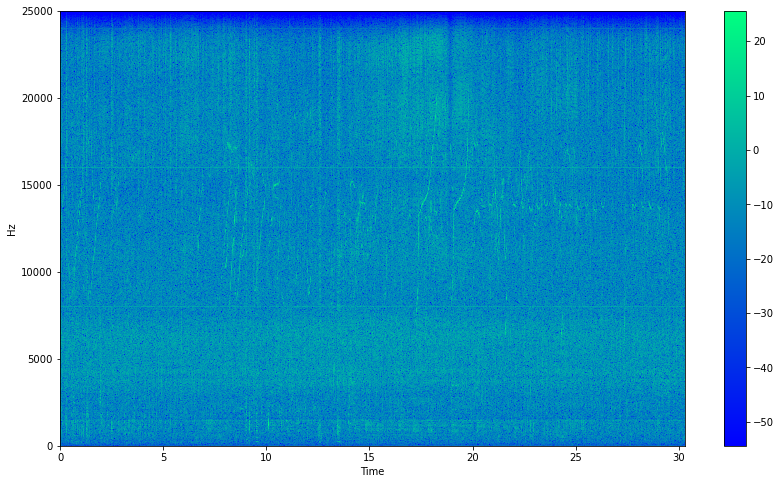

In [13]:
example = '../data/00011346_verypos.e.wav'
verypos, sr = librosa.load(example, sr = 50_000)
verypos_f = librosa.stft(verypos)
Xdb = librosa.amplitude_to_db(abs(verypos_f))
plt.figure(figsize=(14,8))
librosa.display.specshow(Xdb, 
                         sr=sr, x_axis='time', y_axis='hz', cmap='winter')
plt.colorbar()

In [19]:
ipd.Audio(example)

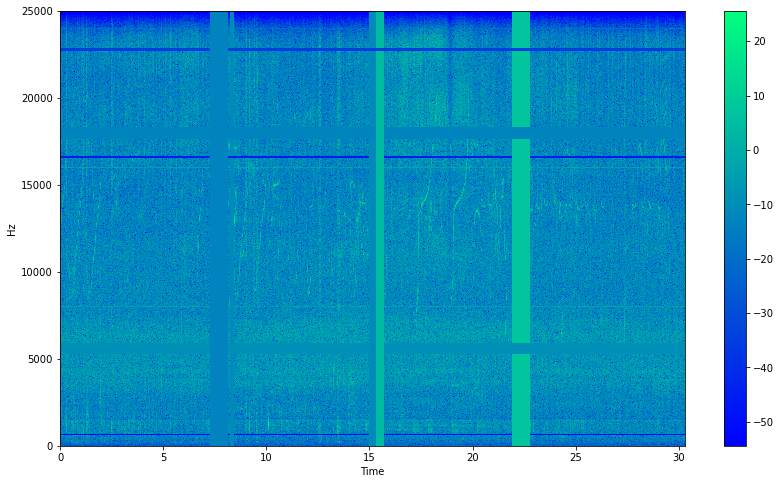

In [17]:
#lots of masks, low % coverage each
plt.figure(figsize=(14,8))
librosa.display.specshow(spec_mask(Xdb, num_mask=5, freq_masking_max_percentage=.03,
                                      time_masking_max_percentage=.03), 
                         sr=sr, x_axis='time', y_axis='hz', cmap='winter')
plt.colorbar()

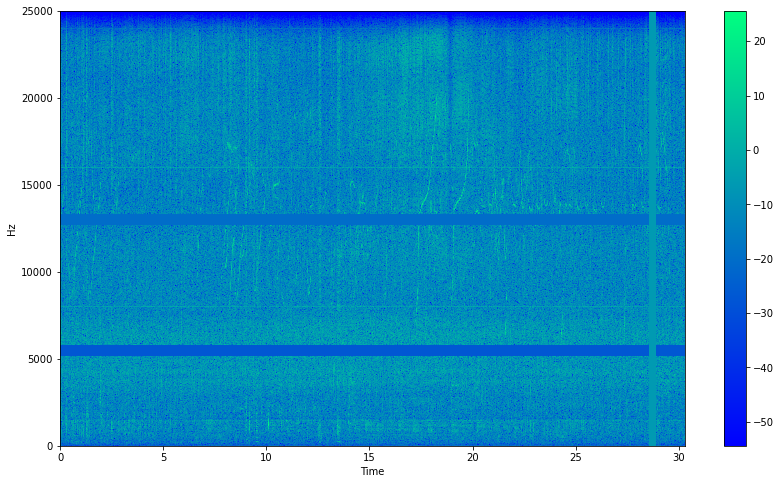

In [21]:
#parameters used in generating masked training data
plt.figure(figsize=(14,8))
librosa.display.specshow(spec_mask(Xdb, num_mask=2, freq_masking_max_percentage=.05,
                                      time_masking_max_percentage=.05), 
                         sr=sr, x_axis='time', y_axis='hz', cmap='winter')
plt.colorbar()

In [11]:
def masked_arrays_tolist(input_list, n_specs, num_mask, 
                         freq_masking_max_percentage, time_masking_max_percentage,
                         ex_path, pos_neg):
    
    subsample = np.random.choice(range(len(input_list)), size = n_specs, replace=False)
    
    masked_specs = []
    
    for s in subsample:
        m = spec_mask(input_list[s], num_mask, freq_masking_max_percentage, time_masking_max_percentage)
        masked_specs.append(m)
    
    with open(f'{ex_path}tts_masked_{pos_neg}.pkl', mode = 'wb') as pickle_out:
        pickle.dump(masked_specs, pickle_out)
    
    print('pau')

In [14]:
#compile list of positives to mask
with open ('../scratch_data/tts_arrays_sm/tts_1_pos.pkl', mode = 'rb') as pickle_in:
    pos1 = pickle.load(pickle_in)
with open ('../scratch_data/tts_arrays_sm/tts_2_pos.pkl', mode = 'rb') as pickle_dos:
    pos2 = pickle.load(pickle_dos)
    
allpos = pos1 + pos2

In [19]:
#generate masked positives to data folder
ex_path = '../scratch_data/tts_arrays_sm/'
masked_arrays_tolist(allpos, n_specs=int(len(allpos)*.3), num_mask = 2,
                     freq_masking_max_percentage = .05, time_masking_max_percentage=.05,
                     ex_path=ex_path, pos_neg='pos')

pau


In [20]:
#compile list of negatives to mask
# tts_4_neg already imported as 'check'
with open ('../scratch_data/tts_arrays_sm/tts_2_neg.pkl', mode = 'rb') as pickle_in:
    neg2 = pickle.load(pickle_in)
enoughneg = check + neg2

In [21]:
#mask and export negatives, 10% of total = 1676
masked_arrays_tolist(enoughneg, n_specs=1676, num_mask = 2,
                     freq_masking_max_percentage = .05, time_masking_max_percentage=.05,
                     ex_path=ex_path, pos_neg='neg')

pau


### Future steps
The parameters I planned to start with based on consultations and literature review are different than those used here. Computing power and time were both limiting factors for the scope of this initial modeling, so most parameters have been downsampled. The resulting features for model input are lower resolution than desired, but will still be informative for future steps. And hey, there's a high chance what I deem important features as a human trying to make sense of these audio and visual representations are not critical for machine learning.  The following specs are either what I wanted to implement here if I had better resources on hand, or what I intend to implement in the future:  

#### Future Work
* n_fft
    * Use multiple n_fft windows: train separate NNs on spectrograms of different n_ffts and compare performance, AND/OR stack/interpolate these different-fft spectrograms into a single unit (multi-channel tensor).
    * n_fft=128 could best capture clicks (bursts and/or trains) 
        * 128/50000 = .00256 sec = 2560$\mu$s per FFT
        * fastest dolphin clicks (burst pulses) ~ 1750 clicks/sec = 570$\mu$s between clicks, each click 50-128 $\mu$s duration 
        * 2560$\mu$s window could capture several clicks; too short for whistles
    * more inclusive window, clicks and whistles: ~ sr/4 = 12500; n_fft=8192(.16 sec); n_fft=16384(.33s)
        * _S. longirostris_ whistle duration = 0.05-1.28s, avg .49s

* win_length: smaller values to better discriminate clicks

* hop_length
    * intent was win_length/4, downsampled to win_length/2 or less here
    
* window
    * Compare model performance using Hann vs. Hamming
    * Blackman might be another window suitable for this audio but what do I know